<a href="https://colab.research.google.com/github/kridtapon/WFO-New-Volume-Momentum-Synergy-/blob/main/WFO_New_Volume_Momentum_Synergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.2 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
<ipython-input-11-3c036e69b499>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-3c036e69b499>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-3c036e69b499>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret


Walk-Forward Optimization Results:
   Year Best_Params  Test_Return
0  2020    (34, 35)     0.518931
1  2021    (34, 35)     0.756187
2  2022    (49, 23)     0.475303
3  2023     (7, 25)     0.032077
4  2024     (8, 25)     1.349456
5  2025     (8, 25)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           855803.555666
Total Return [%]                       755.803556
Benchmark Return [%]                   370.656068
Max Gross Exposure [%]                      100.0
Total Fees Paid                      21812.280474
Max Drawdown [%]                        34.680973
Max Drawdown Duration                       468.0
Total Trades                                   33
Total Closed Trades                            33
Total Open Trades                               0
Open Trade PnL                   

<ipython-input-11-3c036e69b499>:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-3c036e69b499>:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-3c036e69b499>:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-3

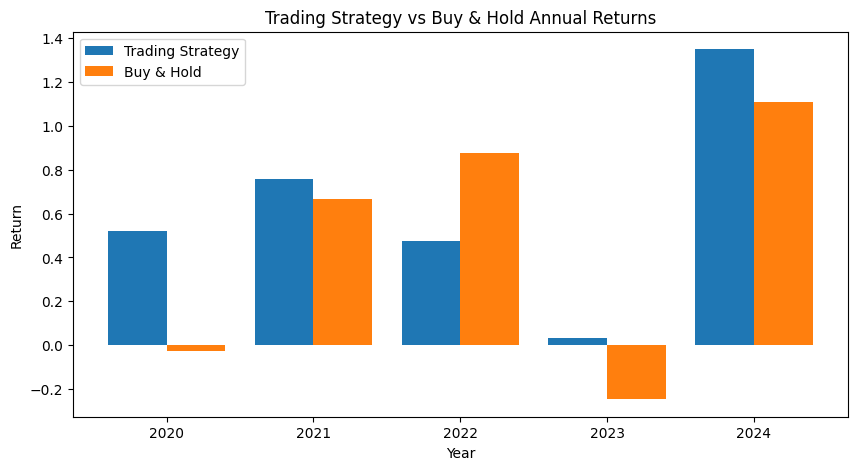

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(data, period=20):
    """
    Calculate Commodity Channel Index (CCI).
    """
    tp = (data['High'] + data['Low'] + data['Close']) / 3  # Typical Price
    sma = tp.rolling(window=period).mean()  # Simple Moving Average
    mean_deviation = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - x.mean())), raw=True)
    cci = (tp - sma) / (0.015 * mean_deviation)
    return cci

# Function to calculate Volume Zone Oscillator (VZO)
def calculate_vzo(data, period=14):
    """
    Calculate Volume Zone Oscillator (VZO).
    """
    close_diff = data['Close'].diff()
    positive_volume = data['Volume'].where(close_diff > 0, 0)
    negative_volume = data['Volume'].where(close_diff < 0, 0)
    total_volume = data['Volume'].rolling(window=period).sum()
    vzo = 100 * (positive_volume.rolling(window=period).sum() - negative_volume.rolling(window=period).sum()) / total_volume
    return vzo

# Walk-forward optimization with CCI + VZO
def walk_forward_optimization_cci_vzo(df, start_year, end_year):
    results = []

    # Define dynamic ranges for CCI and VZO periods
    cci_period_range = range(5, 51)  # Range for CCI periods
    vzo_period_range = range(5, 51)  # Range for VZO periods

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of CCI and VZO parameters
        for params in itertools.product(cci_period_range, vzo_period_range):
            cci_period, vzo_period = params

            # Calculate CCI and VZO on the training data
            train_data['CCI'] = calculate_cci(train_data, cci_period)
            train_data['VZO'] = calculate_vzo(train_data, vzo_period)

            # Generate entry and exit signals based on CCI and VZO
            entries = (train_data['CCI'] > -100) & (train_data['VZO'] > 0)  # Entry when CCI crosses above -100 and VZO > 0
            exits = (train_data['CCI'] < 100) & (train_data['VZO'] < 0)  # Exit when CCI crosses below +100 and VZO < 0

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (cci_period, vzo_period)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply CCI and VZO indicators
        yearly_data['CCI'] = calculate_cci(yearly_data, best_params[0])
        yearly_data['VZO'] = calculate_vzo(yearly_data, best_params[1])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['CCI'] > -100) & (yearly_data['VZO'] > 0)
        exits = (yearly_data['CCI'] < 100) & (yearly_data['VZO'] < 0)

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'TPL'  # TPL! RCL! NRG NQ=F
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_cci_vzo(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply CCI and VZO indicators
    yearly_data['CCI'] = calculate_cci(yearly_data, params[0])
    yearly_data['VZO'] = calculate_vzo(yearly_data, params[1])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['CCI'] > -100) & (yearly_data['VZO'] > 0)
    exits = (yearly_data['CCI'] < 100) & (yearly_data['VZO'] < 0)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [12]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,470656.068015
Total Return [%],370.656068
Benchmark Return [%],370.656068
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],61.427585
